# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

# Installation of Modules

In [0]:
!pip install -q torch==1.0.0 torchvision
!pip install torchvision

tcmalloc: large alloc 1073750016 bytes == 0x61a08000 @  0x7fd4b69682a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# to resolve PIL related error. Try this and then restart runtime.
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
4.0.0


## Fetch Data
Fetch data into colab from online link.

In [0]:

!wget -O cat_to_name.json "https://raw.githubusercontent.com/GabrielePicco/deep-learning-flower-identifier/master/cat_to_name.json"
!wget "https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip" 
!unzip flower_data.zip 
!wget "https://www.dropbox.com/s/3zmf1kq58o909rq/google_test_data.zip?dl=1"

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Google Drive Data


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

#### Imports

In [0]:
# Imports here
import torch
from torchvision import datasets,transforms,models
from torchvision import utils
import numpy as np
from timeit import default_timer as timer
from torch.utils.data import DataLoader, sampler
from torch import optim
import torch.nn as nn
from torch.optim import lr_scheduler

import pandas as pd
from matplotlib import pyplot as plt

print(torch.__version__)



1.0.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

batch_size = 32

In [0]:
# TODO: Define your transforms for the training and validation sets
image_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.Normalize((0.229, 0.224, 0.225),(0.485, 0.456, 0.406)),
                                     transforms.ToTensor()]),
'val': transforms.Compose([
                                     transforms.RandomResizedCrop(224),
                                     transforms.Normalize((0.229, 0.224, 0.225),(0.485, 0.456, 0.406)),
                                     transforms.ToTensor()])
                   }
# TODO: Load the datasets with ImageFolder
#train_data1 = datasets.ImageFolder(train_dir, transform=data_transforms,)
#valid_data1 = datasets.ImageFolder(valid_dir, transform=data_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valid_dir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=test_dir, transform=image_transforms['val']),
    
}

# Dataloader iterators
dataloaders = {
    'train': torch.utils.data.DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=0),
    'val': torch.utils.data.DataLoader(data['val'], batch_size=batch_size, shuffle=True,num_workers=0),
    'test': torch.utils.data.DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=0)
}

print('Num training images: ', len(dataloaders['train']))
print('Num validation images: ', len(dataloaders['val']))
print('Num test images: ', len(dataloaders['test']))

Num training images:  205
Num validation images:  26
Num test images:  32


In [0]:
# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.229, 0.224, 0.225),(0.485, 0.456, 0.406))
                                     ])

test_transform = transforms.Compose([
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.229, 0.224, 0.225),(0.485, 0.456, 0.406))
                                     ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(valid_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(val_data))
print('Num test images: ', len(test_data))


# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

print(type(train_loader),type(dataloaders['train']))

Num training images:  6552
Num test images:  818
Num test images:  995
<class 'torch.utils.data.dataloader.DataLoader'> <class 'torch.utils.data.dataloader.DataLoader'>


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
# one instance
print(cat_to_name['21'])    

fire lily


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# TODO: Build and train your network
train_on_gpu = torch.cuda.is_available
def define_model(model_name,loss_function):
    n_classes = 102 

    if model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        # Freeze model weights
        for param in model.parameters():
            param.requires_grad = False 
        n_inputs = 4096
        model.classifier[6] = nn.Sequential(
                            nn.Linear(n_inputs, 256), 
                            nn.ReLU(), 
                            nn.Dropout(0.4),
                            nn.Linear(256, n_classes),                   
                            nn.LogSoftmax(dim=1))
    
    elif model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        # Freeze model weights
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = 512
        model.fc = nn.Sequential(
                            nn.Linear(n_inputs, 256), 
                            nn.ReLU(), 
                            nn.Dropout(0.4),
                            nn.Linear(256, n_classes),                   
                            nn.LogSoftmax(dim=1))
    
    elif model_name == "resnet152":
        model = models.resnet152(pretrained=True)
        # Freeze model weights
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = 2048
        model.fc = nn.Sequential(
                            nn.Linear(n_inputs, 256), 
                            nn.ReLU(), 
                            nn.Dropout(0.4),
                            nn.Linear(256, n_classes),                   
                            nn.LogSoftmax(dim=1))
    
    elif model_name == "resnet34":
        model = models.resnet34(pretrained=True)
        # Freeze model weights
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = 512
        model.fc = nn.Sequential(
                            nn.Linear(n_inputs, 256), 
                            nn.ReLU(), 
                            nn.Dropout(0.4),
                            nn.Linear(256, n_classes),                   
                            nn.Softmax(dim=1)) 
        
    elif model_name == "resnet34_unfreez":
        model = models.resnet34(pretrained=True)
        # Freeze model weights
        n_inputs = 512
        model.fc = nn.Sequential(
                            nn.Linear(n_inputs, 256), 
                            nn.ReLU(), 
                            nn.Dropout(0.4),
                            nn.Linear(256, n_classes),                   
                            nn.Softmax(dim=1)) 
     
    elif model_name == "inception":
        model = models.inception_v3(pretrained=True)
        # Freeze model weights
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = 4096 
        model.fc = nn.Sequential(
                            nn.Linear(n_inputs, 256), 
                            nn.ReLU(), 
                            nn.Dropout(0.4),
                            nn.Linear(256, n_classes),                   
                            nn.LogSoftmax(dim=1))
        
    else:
        print("Name not recognized")
  
   
 
  
    # use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    model.to(device)  
  
    # Loss and optimizer
    if loss_function == "NLLLoss":
        criteration = nn.NLLLoss()
    elif loss_function == "CrossEntropy":
        criteration = nn.CrossEntropyLoss()
    else:
        print("loss function not recognizedable")
    
    
    optimizer = optim.Adadelta(model.parameters())
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    return model, criteration, optimizer, scheduler

In [0]:
def train(model, criterion, optimizer, train_loader, valid_loader, save_file_name, 
          max_epochs_stop=3, n_epochs=20):
    """
    Train a PyTorch Model
    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    print_every = 1
    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):
        scheduler.step()
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name+'.pt')
                    torch.save(model, save_file_name+'_model'+'.pt')
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

               ##################################################################

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name+'.pt'))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history
                      
               #################################################################

    # Attach the optimizer
    model.optimizer = optimizer
    
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')
    
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    
    return model, history

In [0]:
def plot_history(history,title):
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)  
  plt.plot(history['train_loss'].values, label="train loss")
  plt.plot(history['valid_loss'].values, label="validation loss")
  plt.legend()
  plt.xlabel("Number of epochs")
  plt.ylabel("loss")
  plt.title(title)
 
    
  plt.subplot(1, 2, 2)
  plt.plot(history['train_acc'].values, label="train accuracy")
  plt.plot(history['valid_acc'].values, label="validation accuracy")
  plt.legend()
  plt.xlabel("Number of epochs")
  plt.ylabel("accuracy")
  plt.title(title)
  plt.tight_layout()

  plt.show()

In [0]:
#model, criteration, optimizer = define_model("resnet18")
from google.colab import drive
drive.mount('/content/gdrive')

## Training 3 differentn networks

- vgg 
- resenet
- alexnet

Training: resnet34 NLLLoss
Starting Training from Scratch.

Epoch: 0	100.00% complete. 72.95 seconds elapsed in epoch.
Epoch: 0 	Training Loss: -0.0445 	Validation Loss: -0.1038
		Training Accuracy: 5.05%	 Validation Accuracy: 11.25%
Epoch: 1	100.00% complete. 72.60 seconds elapsed in epoch.
Epoch: 1 	Training Loss: -0.1206 	Validation Loss: -0.1329
		Training Accuracy: 12.67%	 Validation Accuracy: 13.45%
Epoch: 2	100.00% complete. 72.58 seconds elapsed in epoch.
Epoch: 2 	Training Loss: -0.1381 	Validation Loss: -0.1689
		Training Accuracy: 14.38%	 Validation Accuracy: 17.36%
Epoch: 3	100.00% complete. 73.43 seconds elapsed in epoch.
Epoch: 3 	Training Loss: -0.1608 	Validation Loss: -0.2001
		Training Accuracy: 16.54%	 Validation Accuracy: 20.42%
Epoch: 4	100.00% complete. 72.51 seconds elapsed in epoch.
Epoch: 4 	Training Loss: -0.2031 	Validation Loss: -0.2398
		Training Accuracy: 21.23%	 Validation Accuracy: 25.31%
Epoch: 5	100.00% complete. 72.27 seconds elapsed in epoch.
Epoch: 

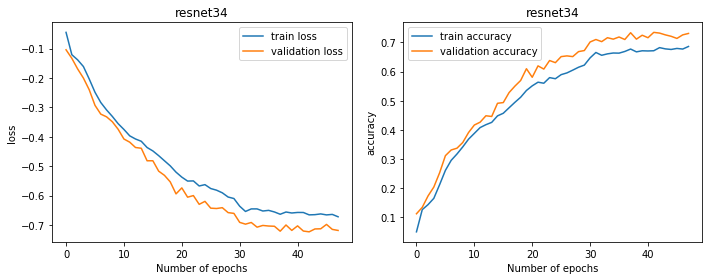

Training: resnet34 CrossEntropy
Starting Training from Scratch.

Epoch: 0	100.00% complete. 70.16 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 4.5834 	Validation Loss: 4.5498
		Training Accuracy: 6.11%	 Validation Accuracy: 9.05%
Epoch: 1	100.00% complete. 69.92 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 4.5261 	Validation Loss: 4.5027
		Training Accuracy: 11.87%	 Validation Accuracy: 14.30%
Epoch: 2	100.00% complete. 69.97 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 4.4858 	Validation Loss: 4.4648
		Training Accuracy: 16.21%	 Validation Accuracy: 18.46%
Epoch: 3	100.00% complete. 69.86 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 4.4466 	Validation Loss: 4.4303
		Training Accuracy: 20.36%	 Validation Accuracy: 21.64%
Epoch: 4	100.00% complete. 69.87 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 4.4148 	Validation Loss: 4.3842
		Training Accuracy: 23.43%	 Validation Accuracy: 26.16%
Epoch: 5	100.00% complete. 70.46 seconds elapsed in epoch.
Epoch: 5 	Tra

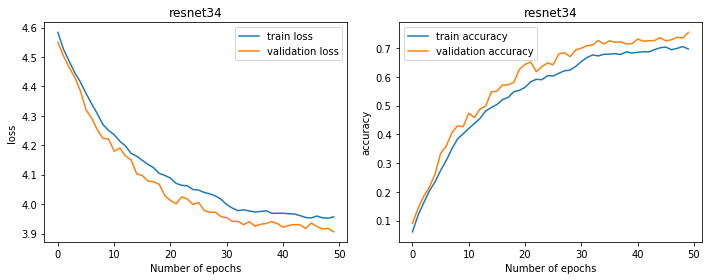

In [0]:
epochs_n = 50

model_names = ["resnet34"]
losses  = ["NLLLoss","CrossEntropy"]

for model_name in model_names:
    for loss in losses:
      print("Training:",model_name,loss)
      # define model
      model, criteration, optimizer, scheduler = define_model(model_name,loss)
      save_file_name = model_name  
      # train
      model, history = train(
          model,
          criteration,
          optimizer,
          train_loader,
          val_loader,
          
          save_file_name=save_file_name,
          max_epochs_stop=5,
          n_epochs=epochs_n)#,
          #print_every=1)
            
      # plot
      plot_history(history,model_name)
      # save 
      model_save_name = model_name+'_ep'+str(epochs_n)+str(loss)+'.pt'
      #path = F"/content/gdrive/My Drive/pytorch_challenge_save/{model_save_name}" 
      path = F"./saved_models/{model_save_name}" 
      torch.save(model,model_save_name)
    
      file_save_name = model_name+'_ep'+str(epochs_n)+str(loss)+'.csv'
      path = F"./saved_models/{model_save_name}" 
      history.to_csv(file_save_name, sep='\t')


### Results

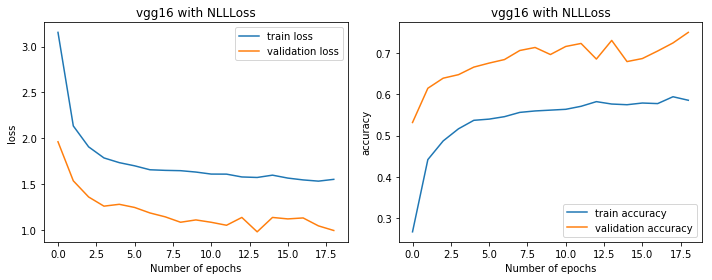

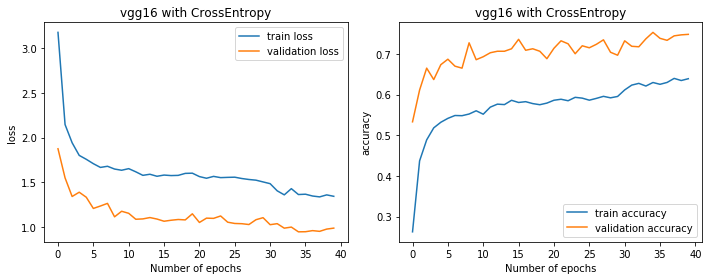

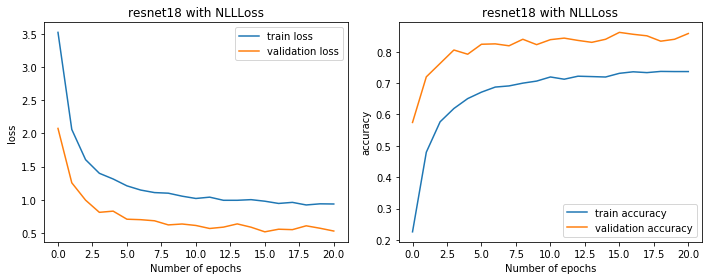

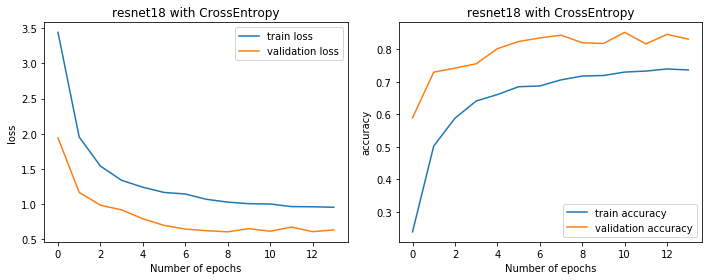

In [0]:
model_names = ["vgg16","resnet18","resnet34"]
losses  = ["NLLLoss","CrossEntropy"]
for model_name in model_names:
    for loss in losses:
        result = pd.read_csv(model_name+'_ep'+str(50)+loss+'.csv',sep='\t')
        title = model_name +' with '+loss
        plot_history(result,title)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

### Upload Weights on Udacity

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'resnet18.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [0]:
# TODO: Save the checkpoint 
model.load_state_dict(torch.load("result.pt"))
model.eval()

In [0]:
model_save_name = 'abc.pt'
path = F"/content/gdrive/My Drive/pytorch_challenge_save/{model_save_name}" 
torch.save(model,path)

In [0]:
model